/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_97384/1375955833.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_97384/1375955833.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_97384/1375955833.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

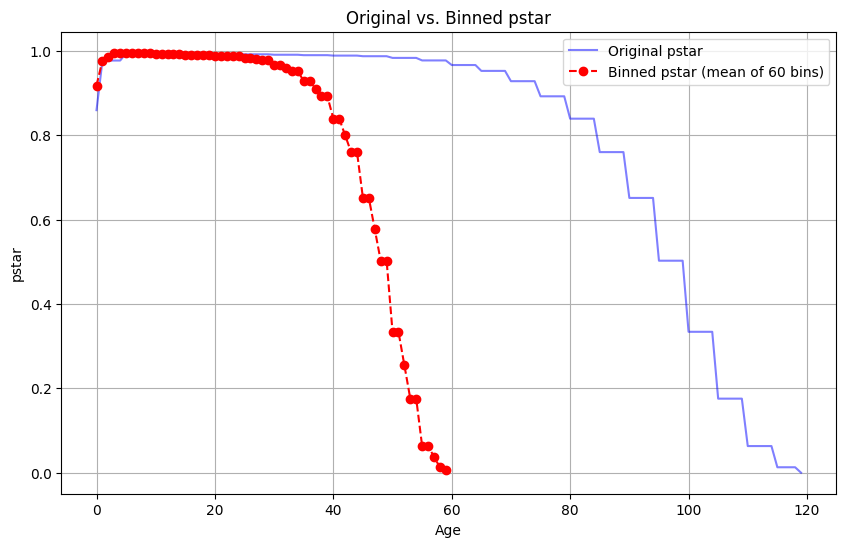

In [30]:
import pandas as pd

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()
new_max_age = 60
old_max_age = vec1['age'].max()
scale_factor = new_max_age / old_max_age
scale_factor = 1
other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)

binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
    binned_col[col] = binned_col[col] * scale_factor
    binned_vec[col] = binned_col[col]
    
bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()
plt.figure(figsize=(10, 6))
plt.plot(vec1['age'], vec1['pstar'], label='Original pstar', color='blue', alpha=0.5)

plt.plot(binned_vec['age_new'], binned_vec['pstar'], label='Binned pstar (mean of 60 bins)', color='red', linestyle='--', marker='o')

plt.title('Original vs. Binned pstar')
plt.xlabel('Age')
plt.ylabel('pstar')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
binned_vec

,age_new,rho,pstar,mortparms
0,0,0.181042,0.462938,1.530543
1,1,0.262058,0.492846,1.392485
2,2,0.319086,0.497230,1.169634
3,3,0.364799,0.501614,0.946782
4,4,0.405534,0.501614,0.946782
5,5,0.441290,0.502186,0.883579
6,6,0.468446,0.502186,0.883579
7,7,0.493339,0.501827,0.901481
8,8,0.493792,0.501469,0.919384
9,9,0.488361,0.501469,0.919384
